In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import sys
import os
from filterpy.monte_carlo import systematic_resample
import scipy as sp
%matplotlib inline

In [2]:
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.path.dirname('utils'), 
                  os.pardir)
)
sys.path.append(PROJECT_ROOT)

In [3]:
from filterscripts import distance_map

c:\Users\mso\Anaconda3\envs\car\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Load Distance Map

In [4]:
dm = distance_map.DistanceMap(1, 100, 'road_points_data_test')

Converted Points (135, 2)
(2195, 2340)


## Create Uniform Particles

In [5]:
from numpy.random import uniform

def create_uniform_particles(x_range, y_range, x_dot_range, y_dot_range,x_ddot_range, y_ddot_range, theta_range, delta_range,N):
    particles = np.empty((N, 8))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(x_dot_range[0], x_dot_range[1], size=N)
    particles[:, 3] = uniform(y_dot_range[0], y_dot_range[1], size=N)
    particles[:, 4] = uniform(x_ddot_range[0], x_ddot_range[1], size=N)
    particles[:, 5] = uniform(y_ddot_range[0], y_ddot_range[1], size=N)    
    particles[:, 6] = uniform(theta_range[0], theta_range[1], size=N)
    particles[:, 7] = uniform(delta_range[0], delta_range[1], size=N)
    particles[:, 6] %= 2 * np.pi
    particles[:, 7] %= 2 * np.pi
    return particles

## Recreation of the model
We have our state: 

$\vec x = \begin{bmatrix} x, y, \dot x, \dot y, \ddot x , \ddot y, \theta, \delta \end{bmatrix}^T$

And we have our control input: 
$\vec u = \begin{bmatrix} \ddot x_u, \ddot y_u, \varphi \end{bmatrix}$ 

We also have our measurements: 
$\vec z = \begin{bmatrix} \ddot x_z, \ddot y_z, \theta \end{bmatrix}$ 

The state transfer function does the following calculation: 

$$
\vec x_{t+1} = 
\begin{bmatrix} x_{t+1}\\ y_{t+1}\\ \dot x_{t+1}\\
\dot y_{t+1}\\
\ddot x_{t+1}\\
\ddot y_{t+1} \\
\theta_{t+1} \\ 
\delta_{t+1} \\
\end{bmatrix}
=
\begin{bmatrix} 
x_t + v\cos(\theta_t + \delta_t)  \Delta t\\ 
y_t + v\sin(\theta_t + \delta_t)  \Delta t\\ 
\dot x_t + \ddot x_{t} \Delta t\\ 
\dot y_t + \ddot y_{t} \Delta t\\
%\ddot x_t + \dddot x_t \Delta t \\ 
%\ddot y_t + \dddot y_t \Delta t\\ 
\ddot x_{u_t}\\
\ddot y_{u_t}\\
\theta_t + \frac{v\sin(\delta)}{L} \Delta t\\ 
\delta + \varphi \Delta t
\end{bmatrix}$$

In [6]:
# x = x-0,y-1,x_dot-2, y_dot-3, x_ddot-4, y_ddot-5, theta-6, delta-7
# u = acc_x, acc_y, steering 
def F(x, u, step, L): 
    # calculate nect velocity
    x_dot_next = x[2] + (x[4] * step)
    y_dot_next = x[3] + (x[5] * step)
    # control input as next acceleration
    x_ddot_next = u[0]
    y_ddot_next = u[1]
    # calculate velocity scalar
    velocity = np.linalg.norm((x[2], x[3]))
    # get next position
    x_next = x[0] + (velocity*np.cos(x[6] + x[7]) * step)
    y_next = x[1] + (velocity*np.sin(x[6] + x[7]) * step)
    #calculate theta and delta
    theta_next = x[6] + (((velocity*np.sin(x[7]))/L) * step)
    delta_next = x[7] + (u[2] * step)
    
    
    return np.array([x_next, y_next,x_dot_next, y_dot_next, x_ddot_next, y_ddot_next, theta_next, delta_next], dtype=object) 

## Create Particle Filter

In [7]:
def predict(particles, u, std, dt, L): 
    N = len(particles) 
    # Needs noise: not in a for loop
    for i in range(len(particles)): 
        particles[i] = F(particles[i], u, dt, L)

def update(particles, weights,z, distance_map):
    for i, particle in enumerate(particles):
        pi = dm.coord_to_image(particle[0:2])
        if (pi[0] < dm.distance_map.shape[1] and pi[0] > 0 and pi[1] < dm.distance_map.shape[0] and pi[1] > 0): 
            road_distance = dm.distance_map[pi[1], pi[0]]# y,x
            rotation_difference = abs((abs(particle[6]-z[2])+180) %360 - 180)# index 6 = theta
            acceleration_difference = np.linalg.norm(abs(z[0:2] - particle[4:5]))
            average_distance = (acceleration_difference + rotation_difference + road_distance) / 3
            weights[i] = average_distance
        else:    
            weights[i] = 0
                
    weights += 1.e-300
    weights /= sum(weights) # normalize
    #print(weights)

    
def estimate(particles, weight): 
    pos = particles[:,0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var


def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))
    
def neff(weights):
    return 1. / np.sum(np.square(weights))

## Load and Prepare IMU Data

In [24]:
def get_rotation_matrix(theta): 
    return np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

In [48]:
simulation_data = pd.read_csv("../data/Simulation_test_run27_07_22_12_20_54.csv")
local_acc = np.stack((simulation_data['accelerometer_x'], simulation_data['accelerometer_y']), axis = 1)

matrices = []
for o in simulation_data['orientations'].values: 
    matrices.append(get_rotation_matrix(o))
matrices = np.array(matrices)

global_acc = []
for i in range(len(matrices)): 
    global_acc.append(np.dot(local_acc[i], matrices[i]))
global_acc = np.array(global_acc)
simulation_data['accelerometer_x'] = global_acc[:, 0]
simulation_data['accelerometer_y'] = global_acc[:, 1]

simulation_data['positions_y'] = -simulation_data['positions_y']

In [51]:
def plot_particles_and_mean(particles, weights, mu, ground_truth): 
    converted_particles = []
    plt.imshow(dm.map_array, cmap="gray")
    for i, rp in enumerate(particles): 
        converted_particle = dm.coord_to_image(np.array([rp[0], rp[1]]))
        plt.scatter(converted_particle[0], converted_particle[1], s=weights[i]*500, c='blue')
    converted_particles = np.array(converted_particles)
    mean = dm.coord_to_image(mu)
    plt.plot(mean, 'ro')
    
    converted_gt = []
    for g in ground_truth: 
        converted_gt.append(dm.coord_to_image(g))
    converted_gt = np.array(converted_gt)
    plt.scatter(converted_gt[:,0],converted_gt[:,1], c="yellow")
    plt.show()

## First test

Faked Control Inputs

Real COntrol Inputs

In [32]:
us = np.stack([simulation_data['acc_x'], simulation_data['acc_y'], simulation_data['steering'].values], axis=1)

In [33]:
zs = np.stack([simulation_data['accelerometer_x'], simulation_data['accelerometer_y'], simulation_data['orientations']], axis=1)

In [49]:
ground_truth = np.stack([simulation_data['positions_x'], simulation_data['positions_y']], axis=1)

In [36]:
seconds = 60
dt = 1/10
Ts=simulation_data['timestamps'].values
xs = []
L = 1.8
N = 500

x_min = dm.road_points[:,0].min()
x_max = dm.road_points[:,0].max()

y_min = dm.road_points[:,1].min()
y_max = dm.road_points[:,1].max()


x_range = [x_min, x_max]
y_range = [y_min, y_max]
x_dot_range = [0, 10]
y_dot_range = [0, 10]
x_ddot_range = [0, 10]
y_ddot_range = [0, 10]

theta_range = [0,2*np.pi]
delta_range = [-np.pi/2, np.pi/2]
particles = create_uniform_particles(x_range, y_range, x_dot_range, y_dot_range,x_ddot_range, y_ddot_range, theta_range, delta_range, N)
weights = np.full((particles.shape[0],), 1/particles.shape[0])

shall_plot = True

for i,u in enumerate(Ts): 
    predict(particles, us[i], 0.02, Ts[i] - Ts[i-1], L)
    
    update(particles, weights,zs[i], dm.distance_map)
    
    if (neff(weights) < N/20): 
        print("resampled")
        indexes = systematic_resample(weights)
        resample_from_index(particles, weights, indexes)
        assert np.allclose(weights, 1/N)
 
    mu, var = estimate(particles,weights)
    
 
    xs.append(mu)
xs = np.array(xs)


resampled


## Plot particles

In [53]:
plot_particles_and_mean(particles, weights, xs[len(xs)-1], ground_truth)


In [94]:
converted_particles = []
for rp in particles: 
    converted_particles.append(dm.coord_to_image(np.array([rp[0], rp[1]])))
converted_particles = np.array(converted_particles)

In [95]:
for i, x in enumerate(xs): 
    xs[i] = dm.coord_to_image(x)

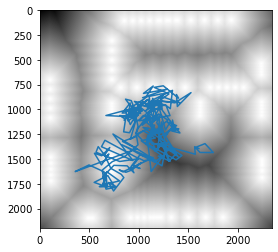

In [100]:
plt.imshow(dm.distance_map, cmap="gray")

#plt.scatter(converted_particles[:,0], converted_particles[:,1])
plt.plot(xs[:,0], xs[:,1])
plt.show()

In [118]:
np.delete(particles,1)

array([  89.87601539,    5.0498498 ,    7.04957677,    6.21794897,
          1.45478145, -105.70230154,   43.13096862,    3.80378066,
          1.87258304,    5.86148025,    4.88933962,   98.39890965,
         29.8924621 ,    3.16951098,    8.8262027 ,    0.19607461,
          1.14164864,  -80.00001231,   33.76801197,    1.77112524,
          8.77728219,    2.97334356,    1.22797221,  -22.65526556,
         48.4184837 ,    4.11103464,    8.87715832,    5.41262946,
          0.51397297,  -97.16700096,   18.15731864,    9.01514783,
          9.42057396,    5.59581735,    4.88502452,  -60.94060905,
        -19.00678056,    2.78089541,    0.88077057,    0.68754409,
          4.77713649,   75.65490949,  -21.77465498,    4.0160926 ,
          5.7925454 ,    3.07008927,    1.10135832,   68.05551041,
         -7.93227455,    0.9160211 ,    1.9939821 ,    5.21538   ,
          4.84651794,  -60.40711443,  -19.72959774,    9.64086559,
          2.04230472,    2.83494334,    5.23008751])

In [80]:
len(dm.distance_map)

2195

In [81]:
a = 10
b = 360
print(abs((abs(a-b)+180) %360 - 180))

10


In [74]:
630 % 360 -180


90